### Multi-Conditional Graph Variational Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal, kl_divergence

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
from data.dataset import QM9GraphDataset, create_data_loaders
from mgcvae import MGCVAE
from trainer import MGCVAETrainer

In [3]:
dataset = QM9GraphDataset(csv_path='./data/qm9_bbbp.csv')

Processing...


Processing 2142 molecules...
Successfully processed 2142 molecules, failed: 0


Done!


In [4]:
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=4)

Dataset splits — Train: 1713, Val: 214, Test: 215


In [5]:
model_config = {
    'node_dim': 29,
    'edge_dim': 6,
    'latent_dim': 32,
    'hidden_dim': 64,
    'num_properties': 1,
    'num_layers': 3,
    'heads': 4,
    'max_nodes': 20,
    'beta': 0.01,      # Start with low KL weight
    'gamma': 1.0,      # Property prediction weight
    'dropout': 0.1
}

In [6]:
model = MGCVAE(**model_config).to(device)

In [7]:
trainer = MGCVAETrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=1e-3,
    device=device,
    save_dir='checkpoints/mgcvae'
)

Starting MGCVAE training for 10 epochs
Model parameters: 105,216
Device: mps

Epoch 1/10


Validation: 100%|██████████| 54/54 [00:59<00:00,  1.10s/it]


New best model saved! Val loss: 1.0758
Train Loss: 1.4417 | Val Loss: 1.0758
Recon: 1.2525 | KL: 4.5291 | Prop: 0.1439
LR: 1.00e-03 | Patience: 0/30

Epoch 2/10


Validation: 100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


New best model saved! Val loss: 0.9790
Train Loss: 1.0681 | Val Loss: 0.9790
Recon: 0.9455 | KL: 1.8110 | Prop: 0.1044
LR: 1.00e-03 | Patience: 0/30

Epoch 3/10


Validation: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


New best model saved! Val loss: 0.9251
Train Loss: 1.0170 | Val Loss: 0.9251
Recon: 0.8960 | KL: 1.9531 | Prop: 0.1015
LR: 1.00e-03 | Patience: 0/30

Epoch 4/10


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.08it/s]


New best model saved! Val loss: 0.9225
Train Loss: 0.9983 | Val Loss: 0.9225
Recon: 0.8822 | KL: 1.8179 | Prop: 0.0980
LR: 1.00e-03 | Patience: 0/30

Epoch 5/10


Validation: 100%|██████████| 54/54 [00:28<00:00,  1.88it/s]


Train Loss: 0.9813 | Val Loss: 0.9342
Recon: 0.8660 | KL: 1.9967 | Prop: 0.0954
LR: 1.00e-03 | Patience: 1/30

Epoch 6/10


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.07it/s]


New best model saved! Val loss: 0.9088
Train Loss: 0.9665 | Val Loss: 0.9088
Recon: 0.8535 | KL: 1.9599 | Prop: 0.0934
LR: 1.00e-03 | Patience: 0/30

Epoch 7/10


Validation: 100%|██████████| 54/54 [00:25<00:00,  2.10it/s]


New best model saved! Val loss: 0.9001
Train Loss: 0.9577 | Val Loss: 0.9001
Recon: 0.8454 | KL: 2.1181 | Prop: 0.0910
LR: 1.00e-03 | Patience: 0/30

Epoch 8/10


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.00it/s]


Train Loss: 0.9538 | Val Loss: 0.9031
Recon: 0.8406 | KL: 2.4767 | Prop: 0.0884
LR: 1.00e-03 | Patience: 1/30

Epoch 9/10


Validation: 100%|██████████| 54/54 [00:25<00:00,  2.12it/s]


New best model saved! Val loss: 0.8801
Train Loss: 0.9418 | Val Loss: 0.8801
Recon: 0.8279 | KL: 2.3738 | Prop: 0.0902
LR: 1.00e-03 | Patience: 0/30

Epoch 10/10


Validation: 100%|██████████| 54/54 [00:28<00:00,  1.87it/s]


New best model saved! Val loss: 0.8748
Train Loss: 0.9403 | Val Loss: 0.8748
Recon: 0.8287 | KL: 2.3963 | Prop: 0.0876
LR: 1.00e-03 | Patience: 0/30


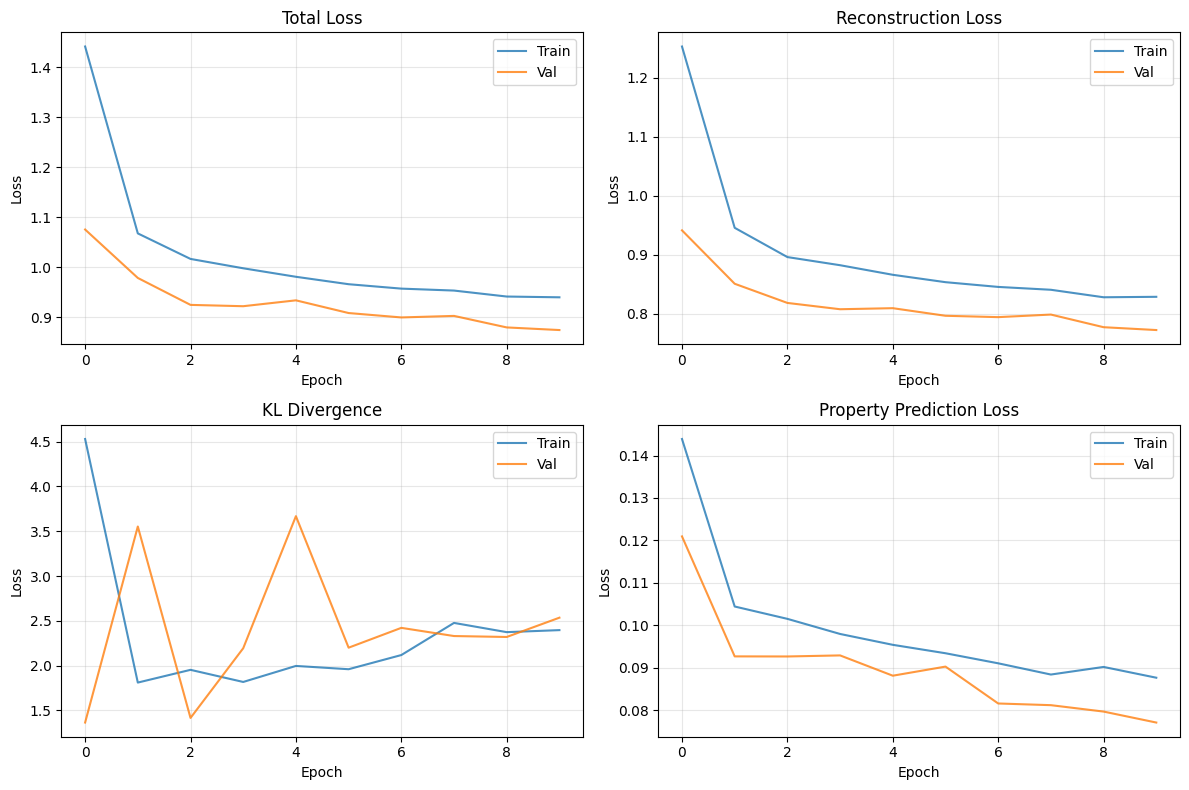

Training completed!


In [8]:
train_metrics, val_metrics = trainer.train(num_epochs=10)

### Re-load Model from Checkpoint

In [12]:
def load_from_checkpoint(checkpoint_path, device='mps'):
    """
    Load MGCVAE model from checkpoint
    
    Args:
        checkpoint_path: Path to checkpoint .pth file
        device: Device to load model on
    
    Returns:
        model: Loaded MGCVAE model
        checkpoint: Full checkpoint dictionary (optimizer state, metrics, etc.)
    """
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Extract model config from checkpoint
    config = checkpoint['model_config']
    
    # Create model with saved configuration
    model = MGCVAE(
        node_dim=config['node_dim'],
        edge_dim=config['edge_dim'],
        latent_dim=config['latent_dim'],
        hidden_dim=config.get('hidden_dim', 64),  # Default if not in old checkpoints
        num_properties=config['num_properties'],
        num_layers=config.get('num_layers', 3),   # Default if not in old checkpoints
        heads=config.get('heads', 4),             # Default if not in old checkpoints
        max_nodes=config['max_nodes'],
        beta=config['beta'],
        gamma=config['gamma'],
        dropout=config.get('dropout', 0.1)        # Default if not in old checkpoints
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {checkpoint_path}")
    print(f"Epoch: {checkpoint['epoch']}, Best Val Loss: {checkpoint['best_val_loss']:.4f}")
    
    return model, checkpoint

In [13]:
# Load the best model from training
model, checkpoint = load_from_checkpoint('checkpoints/mgcvae/best_model.pth', device=device)

# Model is ready for inference!
# You can also access training history:
print(f"\nTraining stopped at epoch: {checkpoint['epoch']}")
print(f"Final validation loss: {checkpoint['best_val_loss']:.4f}")


Model loaded from checkpoints/mgcvae/best_model.pth
Epoch: 10, Best Val Loss: 0.8748

Training stopped at epoch: 10
Final validation loss: 0.8748
